#### Token-level overlap measurements (F1 / lcs) as sanity check to remove false negatives that nearly contain the same sentence as one of the positive facts

In [3]:
import json, random
import numpy as np
from pprint import pprint
from collections import Counter, defaultdict
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import pickle
import copy
np.set_printoptions(precision=4)

In [1]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-cased", do_lower_case=True)

In [6]:
txt_dataset = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/txt_dataset_J.json", "r"))
print(len(txt_dataset))

7921


In [4]:
# VQA Eval (SQuAD style EM, F1)
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*') 
# Use regex to remove stopwords is way faster than looping by yourself

def compute_vqa_metrics(cands, a):
    if len(cands) == 0: return (0,0,0)
    remove_stop_a = pattern.sub('', a)
    bow_a = tokenizer.tokenize(remove_stop_a) #normalize_text(a).split()
    F1 = []
    EM = 0
    RE = []
    PR = []
    for c in cands:
        remove_stop_c = pattern.sub('', c)
        bow_c = tokenizer.tokenize(remove_stop_c) #normalize_text(c).split()
        if bow_c == bow_a:
            EM = 1
        common = Counter(bow_a) & Counter(bow_c)
        num_same = sum(common.values())
        if num_same == 0:
            return (0,0,0,0,0)
        precision = 1.0 * num_same / len(bow_c)
        recall = 1.0 * num_same / len(bow_a)
        RE.append(recall)
        PR.append(precision)

        f1 = 2*precision*recall / (precision + recall + 1e-5)
        F1.append(f1)
    
    PR_avg = np.mean(PR)
    RE_avg = np.mean(RE)
    F1_avg = np.mean(F1)
    F1_max = np.max(F1)
    return (F1_avg, F1_max, EM, RE_avg, PR_avg)

In [7]:
### find distractors super similar to gold (by F1s)
flat_F1s = []
F1s = []
indx2posnegsim = defaultdict(lambda: [])
for k in txt_dataset:
    if int(k) % 1000 == 0: print(k)
    #guid = str(txt_dataset[k]['Guid'])
    for pos in txt_dataset[k]['SupportingFacts']:
        for neg in txt_dataset[k]['DistractorFacts']:
            F1, _, __, RE, PR = compute_vqa_metrics([neg['fact']], pos['fact'])
            flat_F1s.append(F1)
            indx2posnegsim[k].append(F1)
    if k in indx2posnegsim: F1s.append(max(indx2posnegsim[k]))
    else: print(k)
    

0
922
1000
1066
1250
1436
2000
2494
3000
4000
4310
4487
5000
5369
5649
6000
6886
6927
7000


In [8]:
count = 0
for k in indx2posnegsim:
    if max(indx2posnegsim[k]) > 0.8:
        
        count += 1
        if random.random() < 0.01:
            print(indx2posnegsim[k])
print("count = ", count)

count =  518


/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


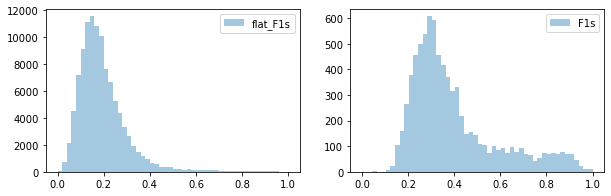

In [9]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,3))
sns.distplot(flat_F1s, ax=axes[0], kde=False, label="flat_F1s")
axes[0].legend()
sns.distplot(F1s, ax=axes[1], kde=False, label="F1s")
axes[1].legend()

0
922
1066
1250
1436
2000
2494
4000
4310
4487
5369
5649
6000
6886
6927
7910


/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


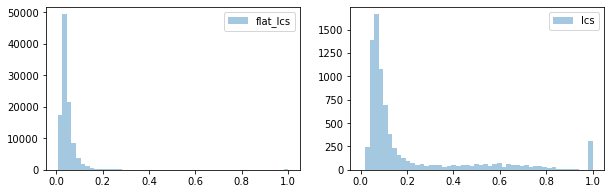

In [10]:
### find distractors super similar to gold (by lcs)
import pylcs
flat_lcs = []
lcs = []
indx2posneglcs = defaultdict(lambda: [])
for k in txt_dataset:
    if int(k) % 2000 == 0: print(k)
    #guid = str(txt_dataset[k]['Guid'])
    for pos in txt_dataset[k]['SupportingFacts']:
        for neg in txt_dataset[k]['DistractorFacts']:
            overlap_ratio = pylcs.lcs2(neg['fact'], pos['fact']) / len(pos['fact'])
            flat_lcs.append(overlap_ratio)
            indx2posneglcs[k].append(overlap_ratio)
    if k in indx2posneglcs: lcs.append(max(indx2posneglcs[k]))
    else: print(k)

print(len(lcs))
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,3))
sns.distplot(flat_lcs, ax=axes[0], kde=False, label="flat_lcs")
axes[0].legend()
sns.distplot(lcs, ax=axes[1], kde=False, label="lcs")
axes[1].legend()

/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


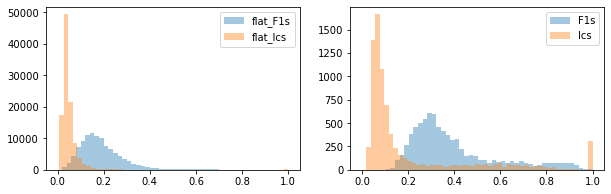

In [11]:
# Plot posnegsim & posneglcs together
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,3))
sns.distplot(flat_F1s, ax=axes[0], kde=False, label="flat_F1s")
sns.distplot(flat_lcs, ax=axes[0], kde=False, label="flat_lcs")
axes[0].legend()
sns.distplot(F1s, ax=axes[1], kde=False, label="F1s")
sns.distplot(lcs, ax=axes[1], kde=False, label="lcs")
axes[1].legend()

854 950
[('1261', 4), ('1916', 3), ('3173', 3), ('4565', 3), ('5343', 3), ('7071', 3), ('105', 2), ('155', 2), ('283', 2), ('284', 2)]


/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


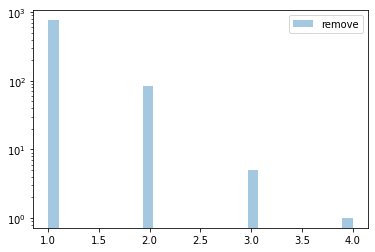

In [12]:
# How many samples got false negatives, and how many mistakes they made.
# Removal criterion: lcs / F1 > threshold
remove = []
for k in indx2posneglcs:
    if len(indx2posneglcs[k]):
        for x in indx2posneglcs[k]:
            if x > 0.6:
                remove.append(k)
print(len(set(remove)), len(remove))
print(Counter(remove).most_common(10))
sns.distplot(list(Counter(remove).values()), kde=False, label="remove")
plt.legend()
plt.yscale('log')

#samples where remaining #negatives < 3 =  52


/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


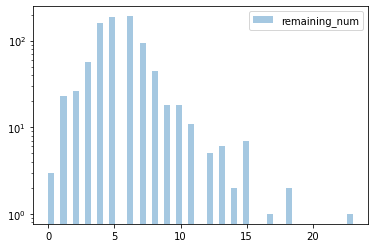

In [13]:
c = Counter(remove)
remaining_num = []
for k in txt_dataset:
    if k in c:
        remaining_num.append(len(txt_dataset[k]['DistractorFacts']) - c[k])
print("#samples where remaining #negatives < 3 = ", np.sum(np.array(remaining_num) < 3))
sns.distplot(remaining_num, kde=False, label="remaining_num")
plt.legend()
plt.yscale('log')

In [15]:
count = 0
for k in indx2posneglcs:
    if max(indx2posneglcs[k]) == 1.0:# and max(indx2posneglcs[k]) < 0.8:
        
        count += 1
        if random.random() < 0.005:
            print(" ------------------------------- ")
            print(k)
            print(indx2posnegsim[k])
print(count)

 ------------------------------- 
740
[0.22608227457710972, 0.2222174113695837, 0.08402899820561116, 0.43835132300336754, 0.150532662899766, 0.9247262111494025, 0.32966534484050003, 0.1526668051252811, 0.09090467221891572, 0.14814322759827742, 0.224714632079789, 0.4770592543232172, 0.1834812727545447, 0.2056025295975886]
 ------------------------------- 
2513
[0.3516434875687915, 0.8760281347179206, 0.2075421699317724, 0.15384115585764085, 0.18749505438392428, 0.25713815212690694, 0.18486960253142404, 0.1610688637175539, 0.25372656168512153, 0.22726798563611783, 0.11289869555119118, 0.2857092921791121]
 ------------------------------- 
4061
[0.883715997864198, 0.15872537177450202, 0.13513013897215906, 0.2758571489845651, 0.16841625276837502, 0.14814316736758273, 0.14814316736758273, 0.3218341604662826, 0.3716765291581502, 0.11110709891031713, 0.138609273752467, 0.19297755475668343, 0.16392944788029185, 0.16666187428046697, 0.12962483728280152, 0.29824071260748375]
308
